# Założenia projektu
## Problem biznesowy
Rozpoznanie u pacjenta objawów raka typu złośliwego czy łagodnego może decydować o metodzie leczenia lub szans przeżycia. Najważniejsze to na jak najwcześniejszym etapie móc wykryć typ raka. Na podstawie zebranego materiału medycznego zostanie przeprowadzone badanie, któego celem będzie stwierdzenie czy możliwe jest skategoryzowanie pacjenta ze względu na typ raka na podstawie mierzalnych wyników medycznych.

## Problem badawczy
Rozpoznanie u pacjenta typu raka (złośliwy lub łagodny) ze względu na mierzalne wyniki medyczne.

## Hipoteza badawcza
Wystąpienie objawów danego typu raka (łagodny lub złośliwy) zależy od towarzyszących mu zmian w organiźmie. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

In [ ]:
# wczytanie data setów
!git clone https://github.com/matzim95/ML-datasets

fatal: destination path 'ML-datasets' already exists and is not an empty directory.


Zebrany materiał źródłowy to dane medyczne. Znajdują się w nim mierzalne zmienne, które wpływają na postawioną diagnozę - czy pacjent ma raka złośliwego czy łagodnego.

Problem, jaki w poniższym projekcie będzie rozwiazywany to zbudowanie modelu który na podstawie dostarczonych danych zdiagnozuje odpowiednią domianę raka u pacjenta (rak złośliwy czy rak łagodny)

---
# sprawdzenie i eksploracja danych

In [ ]:
# wczytanie danych oraz wyprintowanie pierwszych 5 kolumn
dane = pd.read_csv('ML-datasets/breast_cancer.csv')
dane.head()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,benign
1,1002945,5,4,4,5,7,10,3,2,1,benign
2,1015425,3,1,1,1,2,2,3,1,1,benign
3,1016277,6,8,8,1,3,4,3,7,1,benign
4,1017023,4,1,1,3,2,1,3,1,1,benign


**dane dotyczą informacji medycznych pacjenta oraz rozóżniena na to, czy pacient ma raka złośliwego czy łagodnego.
Informacje na ten temat znajdują się w kolumnie 'Class'**

In [ ]:
# sprawdzam informacje o danych
print("ile wierszy x ile kolumn")
print(dane.shape)
# jakie typy danych i czy są braki
print(dane.info())

ile wierszy x ile kolumn
(699, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Sample code number           699 non-null    int64 
 1   Clump Thickness              699 non-null    int64 
 2   Uniformity of Cell Size      699 non-null    int64 
 3   Uniformity of Cell Shape     699 non-null    int64 
 4   Marginal Adhesion            699 non-null    int64 
 5   Single Epithelial Cell Size  699 non-null    int64 
 6   Bare Nuclei                  699 non-null    object
 7   Bland Chromatin              699 non-null    int64 
 8   Normal Nucleoli              699 non-null    int64 
 9   Mitoses                      699 non-null    int64 
 10  Class                        699 non-null    object
dtypes: int64(9), object(2)
memory usage: 60.2+ KB
None


W tabeli znajduje się 699 obserwacji. W żadnej z kolumn nie stwierdzono braków w danych. Kolumna o nazwie 'sample code number' - to unikalne oznaczenie pacjenta, można więc ją bezpiecznie usunąć, nie będzie wykorzystywana w dalszych analizach.

Natomiast warto zwrócić uwagę na kolumnę pt. 'Bare Nuclei' - jest to kolumna typu object (a w niej obiekty typu string). Należy ją więc dokładnie sprawdzić jakiego rodzaju dane są tam przetrzymywane.

W pozostałych kolumnach są dane typu int - więc poza tą jedną kolumną Bare Nuclei dane są spójne.

In [ ]:
# usuwam kolumnę z oznaczeniem unikalnego id pacjenta
dane = dane.drop(["Sample code number"], axis=1)

In [ ]:
dane.groupby('Bare Nuclei').size().to_frame("size").sort_values("size", ascending=False).reset_index()

,Bare Nuclei,size
0,1,402
1,10,132
2,2,30
3,5,30
4,3,28
5,8,21
6,4,19
7,?,16
8,9,9
9,7,8


Kolumna Bare Nuclei jest kolumą, w której znajdują się dane kateogryczne (porządkowe). Przyjmuje 11 wartości od 1 do 10 oraz specjalną kategorię - "?". Najwięcej obserwacji jest przyporządkowanych do kategorii 1 oraz 10. pozostałe grupy są równoliczne. 

In [ ]:
# Ciekawa  jest kategoria "?" z kolumny Barei Nuclei. Do sprawdzenia:
display(dane[dane["Bare Nuclei"] == "?"])
# zmiennna Bare Nuclei przyjmuje wartości od 1-10 i jedną dodatkową wartość "?" 
# Kategoria "?" nie wygląda na odchylającą się od zmiennych. Dla łatwiejszej interpretacji zostaną narzucone kategorie 0 zamiast "?"
dane['Bare Nuclei'] = dane['Bare Nuclei'].replace({"?": "0"})

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
23,8,4,5,1,2,?,7,3,1,malignant
40,6,6,6,9,6,?,7,8,1,benign
139,1,1,1,1,1,?,2,1,1,benign
145,1,1,3,1,2,?,2,1,1,benign
158,1,1,2,1,3,?,1,1,1,benign
164,5,1,1,1,2,?,3,1,1,benign
235,3,1,4,1,2,?,3,1,1,benign
249,3,1,1,1,2,?,3,1,1,benign
275,3,1,3,1,2,?,2,1,1,benign
292,8,8,8,1,2,?,6,10,1,malignant


In [ ]:
# Wyprintowanie statystyk dla zbioru po pierwszych przekształceniach:
dane.describe()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bland Chromatin,Normal Nucleoli,Mitoses
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413
std,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


Pokazanie statystyk dla całego DF pokazuje, że wszystkie zmienne prawdopodonie przyjmują wartości od 0 do 10 (są zmiennymi skokowymi) a zmienna Bare Nuclei z znakami zapytania to po prostu braki w danych. 

W tkaim wypadku najpierw przeliteruje się po wszystkich kolumnach i sprawdzę, czy wszystkie kolumny to kolumny z wartościami 1-10


In [ ]:
# literuję się po wszystkich kolumnach i sprawdzam czy każda z poszczególnych kolumna zawiera dane skokowe i przyjmuje wartości od 1 do 10.
dane.apply(lambda x: x.groupby(x).size(), axis=0)

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
1,145.0,384.0,353.0,407.0,47.0,NaN,152.0,443.0,579.0,NaN
2,50.0,45.0,59.0,58.0,386.0,NaN,166.0,36.0,35.0,NaN
3,108.0,52.0,56.0,58.0,72.0,NaN,165.0,44.0,33.0,NaN
4,80.0,40.0,44.0,33.0,48.0,NaN,40.0,18.0,12.0,NaN
5,130.0,30.0,34.0,23.0,39.0,NaN,34.0,19.0,6.0,NaN
6,34.0,27.0,30.0,22.0,41.0,NaN,10.0,22.0,3.0,NaN
7,23.0,19.0,30.0,13.0,12.0,NaN,73.0,16.0,9.0,NaN
8,46.0,29.0,28.0,25.0,21.0,NaN,28.0,24.0,8.0,NaN
9,14.0,6.0,7.0,5.0,2.0,NaN,11.0,16.0,NaN,NaN
10,69.0,67.0,58.0,55.0,31.0,NaN,20.0,61.0,14.0,NaN


Sprawdzeie statystyk pokazało że:
- zmienna "Bare Nuclei" nie jest zmienną kategoryczną a jest zmienną w kórej brakuje danych ("?" to braki w danych). Wszystkie zmienne są zmiennymi skokowymi przyjmującymi wartości od 1 do 10. Więc zamiana znaków zapytania na 0 była błędną decyzją. Zmienną Bare nuclei należy więc sprowadzić od tej samej skali co inne zmienne.
- Pozostałę zmienne znajdują się każda w tej samej skali (1-10). Są więc zmiennymi skokowymi. W tym przypadku stosowanie normalizacj lub standaryzacji dla tych zmiennych w zbiorze jest bezpodstawne, więc można automatycznie odrzucić te metody przy pracach z ewentualną poprawą modeli.

## co zrobić w przypadku braku danych dla zmiennej Bare Nuclei:

### **Propozycje**
- usunięcie wierszy z brakami danych
- nie włączanie tej kolumny do modelowania
- uzupełnienie braków danych wartościami średnimi (w tym pzypadku medianą)
- zbudowanie modeli regresji który mógłby przewidzieć te dane - na podstawie innych zmiennych. 

### **propozycje rozwiązania:**
- Najłatwiejszą metodą byłoby usunięcie tych danych - jednak do tych braków często jest przypisana klasa "benign" raka (rak łagodny). Z 16 braków danych dla tej zmiennej, 14 ma przypisaną klasę "benign". Może więc to być potencjalna zmienna, która wskazuje na raka łagodnego lub złośliweg.
- Z tych samych przyczyn wydaje się, że usunięcie tej kolumny z danych nie jest zalecane.
- uzupełnienie wartości warościami średnimi - oczekiwanymi - brakuje mi wiedzy medycznej aby podjąć taką decyzję 
- przygotowanie modelu regresji dla uzupełnienia danych - wydaje się czasochłonne, ale jedynie realną opcją.

### **decyzja o brakach**
- w pierwszym kroku zostanie sprawdzone relacja pomiędzy zmienną "Bare Nuclei" a klasą raka (łągodny cz złośliwy). Być może uzupełnienie tej zmiennej wartościami oczekiwanymi (medianą) w zupełności wystarczy.


In [ ]:
dane["Bare Nuclei"] = dane["Bare Nuclei"].astype("int")

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


([<matplotlib.axis.XTick at 0x7f229334a090>,
 [Text(0, 0, 'benign'), Text(0, 0, 'malignant')])

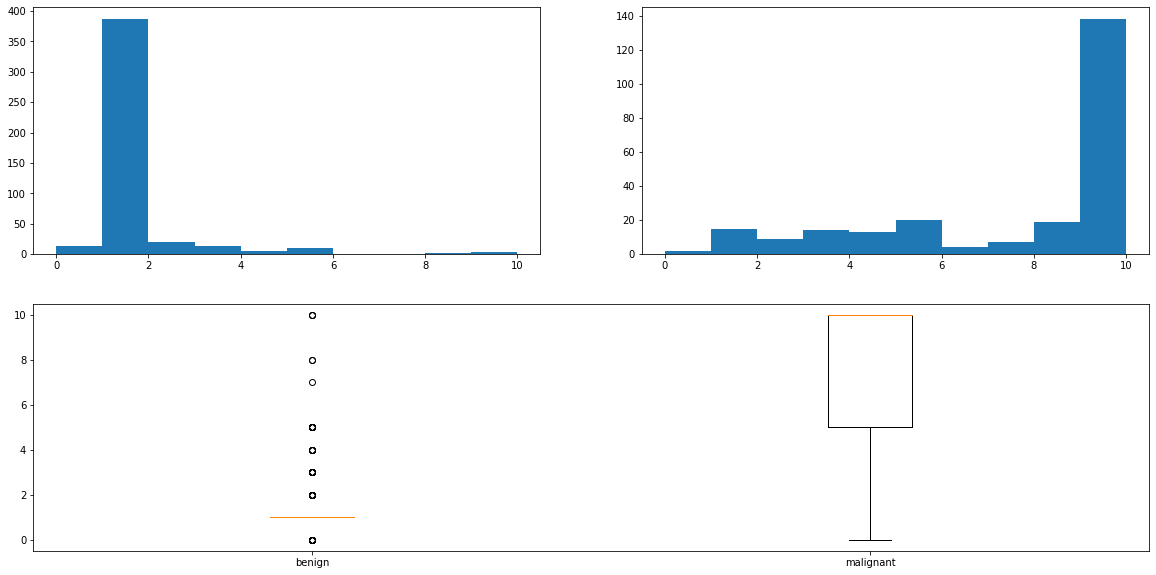

In [ ]:
toBox_benign = dane[dane["Class"] == "benign"]["Bare Nuclei"]
toBox_malignant = dane[dane["Class"] == "malignant"]["Bare Nuclei"]
toBoxPlot = [
         dane[dane["Class"] == "benign"]["Bare Nuclei"].tolist(), 
         dane[dane["Class"] == "malignant"]["Bare Nuclei"].tolist()
         ]

gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize = (20, 10))
ax1 = fig.add_subplot(gs[0, 0]) # row 0, col 0
ax1.hist(toBox_benign)

ax2 = fig.add_subplot(gs[0, 1]) # row 0, col 1
ax2.hist(toBox_malignant)

ax3 = fig.add_subplot(gs[1, :]) # row 1, span all columns
ax3.boxplot(toBoxPlot)
plt.xticks([1, 2], ['benign', 'malignant'])


In [ ]:
print("Mediana dla Bare Nuclei dla łagodnej wersji raka:")
print(dane[dane["Class"] == "benign"]["Bare Nuclei"].median())
print("Mediana dla Bare Nuclei dla złośliwej wersji raka:")
print(dane[dane["Class"] == "malignant"]["Bare Nuclei"].median())

Mediana dla Bare Nuclei dla łagodnej wersji raka:
1.0
Mediana dla Bare Nuclei dla złośliwej wersji raka:
10.0


## Wynik dla braków danych w zmiennej: 'Barei Nuclei'
Zmienna Barei Nuclei przyjmuje zdecydownie niższe wartości dla łagodnej wersji zdiagnozowanego raka (benign) a wyższe dla jego złościwej wersji (malignat). Wobec tego rekomendowane jest podmienienie braków danych medianą dla poszczególnych klas - dla łagodnej wersji raka dla zmiennej Barei Nuclei 1, dla złośliwej wersji raka - 10.


In [ ]:
# podmieniam braki danych dla Barei nuclei odpowiednio medianą dla poszczególnych ktegorii raka łagodnego/złośliwego
# wcześniej podmieniałem "?" na 0. Aktualnie więc zmieniam wartości 0 na mediany i konwertuję tę zmienną
# do takiego saego typu co pozostałe zmienne - typu int.
dane.loc[(dane["Class"] == "benign") & (dane["Bare Nuclei"] == 0), ["Bare Nuclei"]] = 1
dane.loc[(dane["Class"] == "malignant") & (dane["Bare Nuclei"] == 0), ["Bare Nuclei"]] = 10


In [ ]:
dane.describe()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.512160,3.437768,2.866953,1.589413
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.636146,2.438364,3.053634,1.715078
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


Wszystie dane zostały już sprowdzone do jednej skali (1-10). Brak braków w danych wszystie zmienne są porównywalne do siebie.

Możnna przystąpić do ich eksploracji.

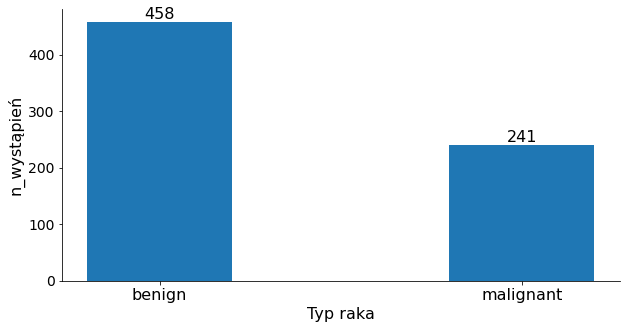

In [ ]:
# rozkład klas
class_share = dane.groupby(["Class"]).size().to_frame("Size").reset_index()
class_share["Class"] = class_share["Class"].astype(str)

fig = plt.figure(figsize = (10, 5))
plt.bar(class_share["Class"], class_share["Size"], width = 0.4)
plt.xlabel("Typ raka", size = 16)
plt.xticks([0, 1], ['benign', 'malignant'], size = 16)
plt.ylabel("n_wystąpień", size = 16)
plt.yticks(size = 14)

for x, y in zip(class_share["Class"], class_share["Size"]):
  plt.text(x = x, y = y+5, s = y, fontdict={"size": 16, "ha": "center"})

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

fig.show()
# Klasy są nieznacznie nierównoliczne. Większa część obserwacji (65%) jest skategoryzowanych jako wystąpienie raka łągodnego, 35% - jako wystąpienie raka złośliwego.
# Jednakże wydaje się, proporcje nie są aż tak mocno zaburzone. 

In [ ]:
# przerabiam zmieną Class na zmienną 0:1. 0 - wystąpienie raka łagodnego, 1 - wystąpienie raka złośliwego.
# tworzę kolumnę dummy gdzie 0 - to oznaczenie raka łagodnego, 1 oznaczenie raka złośliwego
# pozbywam się oryginalnej kolumny
# otrzymuję dwie kolumny  - oznaczenie raka łagodnego i złośliwego
# usuwam kolumnę kategoryzującą raka łagodnego (informacje na ten temat będę miał w kolumnie o raku złośliwym, gdzie wartość 0 to będzie rak łągodny)
# zmieniam nazwę kolumny na "Class" -> aby było spójnie z oznaczeniem w danych
dane = (
    pd.get_dummies(
        dane,
        columns=['Class'],
        drop_first=False)
    ).drop("Class_benign", axis=1)\
    .rename(columns = {"Class_malignant": "Class"})

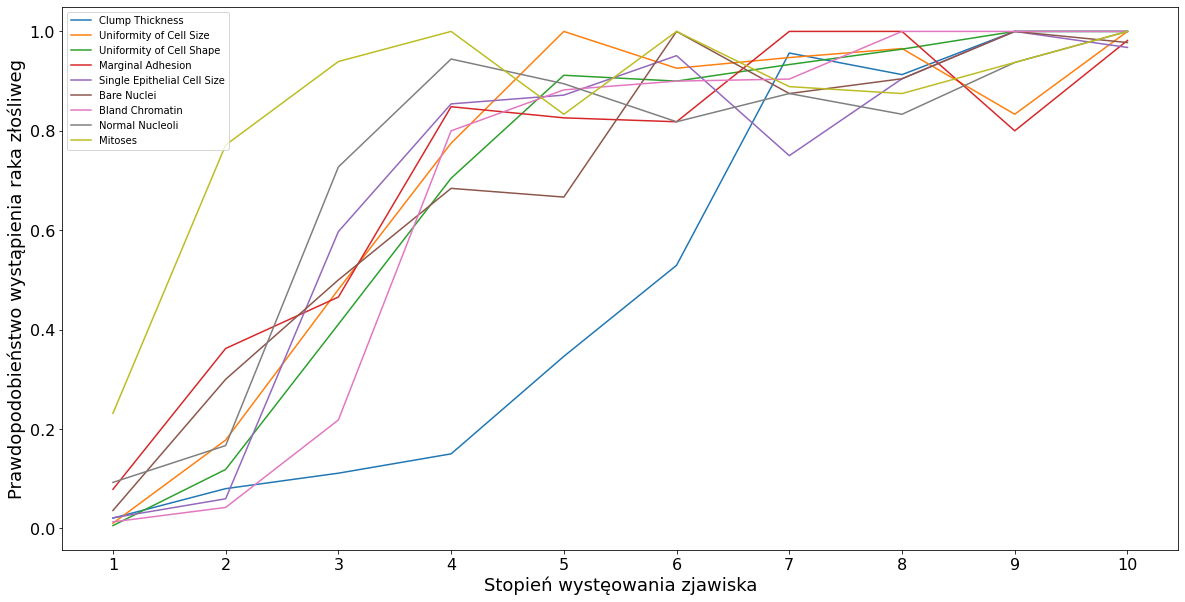

In [ ]:
# wybieram kolumny do sprawdzenia - wszystkie z wyjątkiem kolumny klass - po niej będę się iterował
# jako że zmienną o typie raka sprowadziłęm do przedziału 0 1 dla każdej z grup zmiennej (które przymują wartości skokowe od 1 do 10)
# mogę wyliczyć średnią - prawdopodobieństwo zachorowania na raka złośliwego wraż z zwiększaniem się oznaczenia dla poszczegónej zmiennej

columns_to_check = dane.loc[:, dane.columns != "Class"].columns.tolist()

fig = plt.figure(figsize = (20, 10))

for col in columns_to_check:
  print(
      plt.plot(dane["Class"].groupby(dane[col]).mean(), label = col)
  )
plt.legend(loc="upper left")

plt.xlabel("Stopień wystęowania zjawiska", size = 18) 
plt.xticks(range(1, 11), size = 16) 

plt.ylabel("Prawdopodobieństwo wystąpienia raka złośliweg", size = 18)
plt.yticks(size = 16)
fig.show()

**W przypadku każdej zmiennej - im wyższe oznaczenie, bliższe 10 - tym prawdopobieństwo zachorowania na raka złośliwego wzrasta.**

Dla pewności wyprintujmy wyniki korelacji między zmiennymi na heat mapie

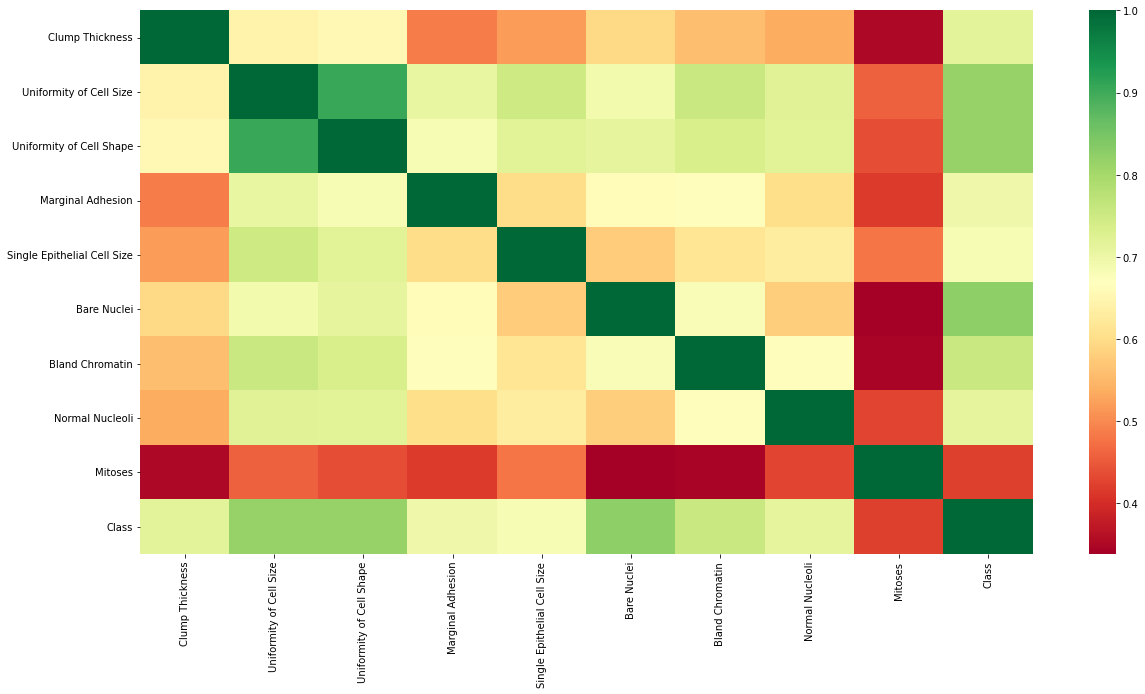

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(dane.corr(), cmap='RdYlGn')

Wszystkie zmienne pozytywnie korelują się ze zmienną typu Class (i występowaniem raka złośliwego, im większa wartość każdej zmiennej, zbliżająca się do 10 - tym ryzyko i prawdopodobieństwo wystąpienia raka złośliwego wzrasta.

Zmienna "Mitoses" umiarkowanie koreluje z zmienną Class. Jednak jak to widać na wykresie liniowym - gdy wrasta wartość tej zmiennej - bardzo szybko rośnie prawdopodobieństwo wystąpienia raka złośliwego (prawie do 1), następnie lekko spada a potem w miarę zwiększania się się wartości tej zmiennej prawdopodobieństwo wystąpienia raka złośliwego ponownie wzrasta. Dlatego ta zmiena właśnie najsłabiej koreluje z zmienną "class", ale i tak jest to pozytywna korelacja (umiarkowanie pozytywna)

---
# Modele ML-owe



## Regresja Logistyczna

Jako, że  problemem, jak należy rozwiązać jest na podstawie obserwacji zaklasyfikowanie pacjenta do grupy czy ma raka łągodnego czy złośliwego - więc jest to problem typowo klasyfikacyjny. 

Pierwszyb wybranym modelem będzie regresja logistyczna - dobrze nadająca się do problemów klasyfikacji dychotomicznych.



In [ ]:
# ładuję paczki niezbędne przy modelowani
from sklearn.model_selection import train_test_split # podział na zbiór testowy i zbiór treningowy
from sklearn.linear_model import LogisticRegression # importuję model regresji logistycznej
from sklearn.metrics import accuracy_score # importuję moduł do sprawdzania skuteczności działania modelu
from sklearn.metrics import recall_score # modułdo wyliczenia wskaźnika czułości
from sklearn.metrics import precision_score # moduł do wyliczenia prezycji modelu
from sklearn.metrics import f1_score # moduł do wyliczenia wskaźnika F1 score
from sklearn.metrics import mean_absolute_error #
from sklearn.metrics import mean_squared_error #
from sklearn.metrics import confusion_matrix # importuję moduł do wylcizenia macierzy pomyłek
from sklearn.model_selection import cross_validate # importuję moduł do cross walidacji

In [ ]:
# funkcja do wyliczania wskaźników skuteczności modelu

def efficiency(
    y_train, 
    y_pred_train, 
    y_test, 
    y_pred, 
    regression=False):
  
  # accuracy
  accuracy_train = accuracy_score(y_train, y_pred_train)
  accuracy_test = accuracy_score(y_test, y_pred)
  # recall
  recall_train = recall_score(y_train, y_pred_train)
  recall_test = recall_score(y_test, y_pred) 
  # precission score
  precision_train = precision_score(y_train, y_pred_train)
  precision_test = precision_score(y_test, y_pred)
  # f1 score
  f1_train = f1_score(y_train, y_pred_train)
  f1_test = f1_score(y_test, y_pred)

  if regression:
    mean_absolute_error_train = mean_absolute_error(y_train, y_pred_train)
    mean_absolute_error_test = mean_absolute_error(y_test, y_pred)
    mean_squared_error_train = mean_squared_error(y_train, y_pred_train)
    mean_squared_error_test = mean_squared_error(y_train, y_pred_train)

    df_dict = {
        'testowy': [
                    accuracy_train, 
                    recall_train, 
                    precision_train, 
                    f1_train,
                    mean_absolute_error_train,
                    mean_squared_error_train],
        'treningowy': [
                       accuracy_test,
                       recall_test, 
                       precision_test, 
                       f1_test,
                       mean_absolute_error_test,
                       mean_squared_error_test]}
  
    df = pd.DataFrame.from_dict(
        df_dict, orient='index',
        columns=[
                 'accuracy', 
                 'recall', 
                 'precision', 
                 'F1', 
                 'mean_absolute_error',
                 'mean_squared_error'])
    
  else:
    df_dict = {
        'treningowy': [accuracy_train, recall_train, precision_train, f1_train],
        'testowy': [accuracy_test, recall_test, precision_test, f1_test]}
          
    df = pd.DataFrame.from_dict(
        df_dict, orient='index',
        columns=['accuracy', 'recall', 'precision', 'F1'])

  return df



In [ ]:
# podział na zmienną zależną i zmienne niezależne 
# dla przypomnienia w zmiennej zależnej 0 jest oznaczony rak łągodny, 1 - rak złośliwy
y = dane["Class"]
X = dane.loc[:, dane.columns != "Class"]

In [ ]:
# podział zbioru danych na zbiór testowy oraz zbió treningowy
# ustawiam parametr stratify tak aby podziałzmiennej zależnej był zrównoważony na zbiór treningowy i testow

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size = 0.2,
    random_state = 42, 
    stratify = y)

In [ ]:
# uruchamiam model regresji logistycznej
model = LogisticRegression()

# trenuję model na podstawie dostarczonych danych
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# sprawdzam działanie modelu i uruchamiam model na danych trningowych i testowych
y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)

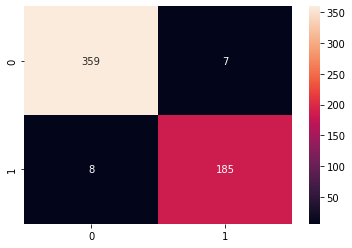

In [ ]:
# wizualizuję sobie macierz pomyłek dla uruchoionego modelu
cm_train = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm_train, annot=True, fmt='d')
plt.show()

Jak widać model nie myli się w wielu przypadkach. Raptem w 15 przypadkach niepoprawnie zaklasyfikował pacjenta do jednej z grup.

Warto sprawdzić też skuteczność działania modelu

In [ ]:
efficiency(
    y_train = y_train,
    y_pred_train = y_pred_train, 
    y_test = y_test, 
    y_pred = y_pred,
    regression = True)

,accuracy,recall,precision,F1,mean_absolute_error,mean_squared_error
testowy,0.973166,0.958549,0.963542,0.961039,3.661896,0.026834
treningowy,0.942857,0.895833,0.934783,0.914894,9.128571,0.026834


Model ma bardzo wysoką suteczność - 97% na zbiorze testowym i prawie 94% na zbiorze treningowym. Poprawnie klasyfikuje wyniki w 97% przypadków a zbiorze treningowym i w 94% przypadków na zbiorze testowym

F1 score jest również bardzo wysoki.

Warto w takim wypadku przeprowadzić jeszcze cross walidację modelu i sprawdzić czy nie mamy do czynienia z przetrenowaniem modelu.

In [ ]:
# przeprowadzam proces cross walidacji
cv_results = cross_validate(
    model, 
    X, y, 
    cv=10)

print(cv_results['test_score'])

[0.91428571 0.97142857 0.95714286 0.91428571 1.         0.97142857
 0.97142857 1.         0.97142857 1.        ]


**wyniki cross walidacji**

Przeprowadzona cross walidacjia wskazała, że model jest skuteczny. Wszystkie wyniki dają podone efekty (od 91% skutecznoci nawet do 100%). Należałoby przeprowadzić dodatkowe testy czy model nie jest przeuczony, ale wydaje się poprawny

**Model gotowy do wrzucenia na produkcję**

In [ ]:
# tabela z wskaźnikami dla modelu regresji
model_scoresd_dict = {"variable": model.feature_names_in_,
                     "intercept": np.repeat(model.intercept_, 9),
                     "coef": model.coef_[0]}

In [ ]:
model_indicators = pd.DataFrame.from_dict(model_scoresd_dict, orient='columns')
display(model_indicators)

,variable,intercept,coef
0,Clump Thickness,-9.498393,0.442434
1,Uniformity of Cell Size,-9.498393,-0.025188
2,Uniformity of Cell Shape,-9.498393,0.279815
3,Marginal Adhesion,-9.498393,0.240761
4,Single Epithelial Cell Size,-9.498393,0.095891
5,Bare Nuclei,-9.498393,0.522057
6,Bland Chromatin,-9.498393,0.350330
7,Normal Nucleoli,-9.498393,0.198329
8,Mitoses,-9.498393,0.533638


## SVM

In [ ]:
from sklearn.svm import SVC # importuję moduł do SVM (SVC Support Vector Classification)

In [ ]:
# dzielę zbió danych na zbiór treningowy oraz testowy
# ustawiam parametr stratify na to, aby byłrówny podział próbek pozytywnie zaklasyfikowanych 
# jako rak złośliwy pomiędzy zbiór treningowy a zbiór testowy

svm_X_train, svm_X_test, svm_y_train, svm_y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [ ]:
# trenuję model

# uruchamiam model
svm = SVC(kernel = 'linear')
# trenuję model na zbiorze treningowym
svm.fit(svm_X_train, svm_y_train)

# sprawdzam wyniki na zbiorze testowym i treningowym
svm_y_pred_train = svm.predict(svm_X_train)
svm_y_pred_test = svm.predict(svm_X_test)

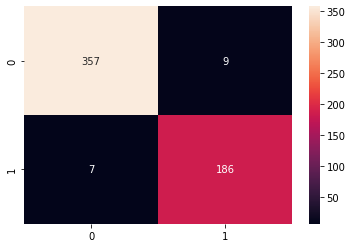

In [ ]:
# wizualizuję sobie macierz pomyłek dla uruchoionego modelu
cm_train = confusion_matrix(svm_y_train, svm_y_pred_train)
sns.heatmap(cm_train, annot=True, fmt='d')
plt.show()

Model SVM na macierzy pomyłek pomylił się w 16 przypadkach. Różnica miedzy modelem regresji logistycznej - 1 przypadek. Jest więc podobnie skuteczny

In [ ]:
# warto sobie wyprintować wskaźniki skuteczności modelu:
# korzystan z wcześniej przygotowanej funkcji do wyprintowania wskaźników
efficiency(
    y_train = svm_y_train,
    y_pred_train = svm_y_pred_train, 
    y_test = svm_y_test, 
    y_pred = svm_y_pred_test,
    regression = False)

,accuracy,recall,precision,F1
treningowy,0.971377,0.963731,0.953846,0.958763
testowy,0.950000,0.916667,0.936170,0.926316


Na zbiorze treningowym model SVM osiąga skuteczność 97% (poprawnie klasyfikuje 97% przypadków). Natomiast na zbiorze testowym - 95%. Wartość wskaźnika F1 score w obu przypadkach sięga również powyżej 90%. 

Warto jeszcze przeprowadzić cross walidację aby upewnić się, że model się nie przeucza.

In [ ]:
# przeprowadzam proces cross walidacji dla modelu svm
cv_results_svm = cross_validate(
    svm, 
    X, y, 
    cv=10)

print(cv_results_svm['test_score'])

[0.91428571 0.97142857 0.97142857 0.91428571 0.98571429 0.97142857
 0.95714286 1.         0.97142857 1.        ]


Wyniki cross walidacji są również do siebie bardzo zbliżone i powyżej 90% skuteczności. Model wydaje się poprawny.

In [ ]:
# trudno byłoby polepszyć ten model SVM ale można jeszcze sprawdzić parametr C - funkcja Grid Search
from sklearn.model_selection import GridSearchCV # importuję moduł to automatycznego poszukiwania najlepszych parametrów dla modelu

In [ ]:
parameter_c = {'C':[0.001, 0.01, 0.1, 1.0, 10, 100, 1000]}

In [ ]:
# iniciuję model SVM
svm_search = SVC()
# inicuję funkcję do poszukiwania najlepszych parametrów na modelu SVM
searcher_svm = GridSearchCV(svm, parameter_c)
# uruchamiam model SVM na wywołanej funkcji GridSearch
searcher_svm.fit(svm_X_train, svm_y_train)

GridSearchCV(estimator=SVC(kernel='linear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000]})

In [ ]:
# uruchamiam model do przewidzenia wartości Y dla wartości testowych i treningowych X
searcher__y_predict_train = searcher_svm.predict(svm_X_train)
searcher__y_predict_test = searcher_svm.predict(svm_X_test)

# sprawdzam statystyki dla modelu searcher svm na podstawie napisanej wcześniej funkcji

efficiency(
    y_train = svm_y_train,
    y_pred_train = searcher__y_predict_train, 
    y_test = svm_y_test, 
    y_pred = searcher__y_predict_test,
    regression = False)

,accuracy,recall,precision,F1
treningowy,0.971377,0.963731,0.953846,0.958763
testowy,0.950000,0.916667,0.936170,0.926316


In [ ]:
print(f"Najlepszy paramter C dla modelu SVM to: {searcher_svm.best_params_}")

Najlepszy paramter C dla modelu SVM to: {'C': 0.1}


Dla pewności tworzymy drugi model SVM dla parametru C ustawionego na 0.1 



In [ ]:
# uruchomienie modelu
svm_2 = SVC(C = 0.1)
svm_2.fit(svm_X_train, svm_y_train)
# przygotowanie wartości predykcyjnych
svm_2_y_predict_train = svm_2.predict(svm_X_train)
sv_2_y_predict_test = svm_2.predict(svm_X_test)

# sprawdzenie statystyk dla predykcji
display(
    efficiency(
      y_train = svm_y_train,
      y_pred_train = svm_2_y_predict_train, 
      y_test = svm_y_test, 
      y_pred = sv_2_y_predict_test,
      regression = False)
)

# przeprowadzenie cross walidacji
cv_results_svm = cross_validate(
    svm_2, 
    X, y, 
    cv=10)

print(cv_results_svm['test_score'])

,accuracy,recall,precision,F1
treningowy,0.967800,0.974093,0.935323,0.954315
testowy,0.964286,0.958333,0.938776,0.948454


[0.91428571 0.97142857 0.97142857 0.91428571 0.98571429 0.97142857
 0.97142857 1.         0.98571429 0.98550725]


Model SVM ustawiony z parametrem C na 0.1 daje podobne wyniki, podobnie skuteczne co model SVM bez poszukwiania tego parametru (a nawet o 1% lepsze na zborze testowym niż model SVM uruchomiony bez parametru C).

Model SVM z parametrem C = 0.1 daje o 1% lepsze wyniki na danych testowych niż model regresji logistycznej.

Będzie więc zapewne lepiej dostosowywał sie do danych których nie zna (na nowo dostarczonych. 


# Wynik
W badaniu zastosowano dwa modele - regresji logistyczej oraz SVM. Model SVM z parametrem C na danych testowych ma o 2% większą skuteczność niż model regresji logistycznej.

Jednakże wydaje się, że w związku z tym, że łatwiej jest interpretować wskaźniki modelu regresji logistycznej (dzięki temu, iż jest to funkcja liniowa i można sprawdzić wyraz wolny oraz współczynników regresji - łatwiejsza jest ona w interpretacji.

Skoro modele dają zbliżone do siebie wyniki - bardziej rozsądne jest wybrać model, który jest łatwiejszy w interpretacji, tzn. regresjię logistyczną.